In [236]:
from jupyter_client import find_connection_file
connection_file = find_connection_file()
print(connection_file)

/home/yonatan/.local/share/jupyter/runtime/kernel-v2-5417KpAsYqpYieXm.json


In [237]:
#Plotting related
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
pio.renderers.default='notebook'

# Scikit-learn related imports
import pyarrow
import pandas as pd
pd.options.mode.copy_on_write = True
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV
from sklearn.metrics import accuracy_score
from scipy.stats import randint, ttest_ind
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from mlxtend.plotting import plot_decision_regions

In [238]:
dataset_col = "Dataset"
uid_col = "uid"
age_col = "Age"
day_col = "Day"
response_col = "Response"
immage_col = "IMMAGE"
strain_col = 'Strain'

In [239]:
# Read in Data and drop missing values
df = pd.read_csv("../data/all_vaccines.csv")
df.dropna(inplace=True, subset=[immage_col, dataset_col, day_col, response_col])

dataset_names = df.Dataset.unique()

##### Plot distribution of studies' N values

<Axes: xlabel='N', ylabel='Count'>

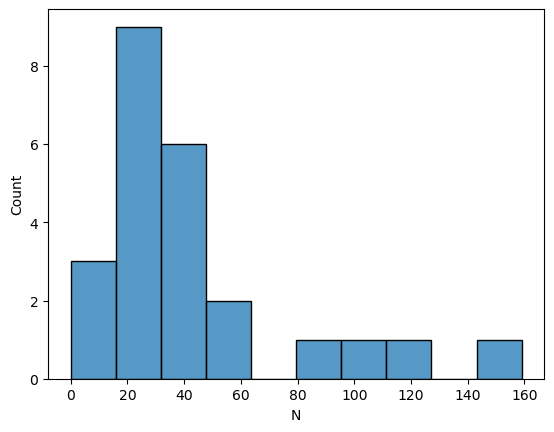

In [240]:
# Plot distribution of N values
N_vals = df[[dataset_col, uid_col]].groupby(dataset_col, as_index=False)[uid_col].nunique()
N_vals = N_vals.rename(columns={uid_col: "N"})
sns.histplot(N_vals.N)

##### Narrow to large datasets only

In [241]:
# Narrow N_v to large datasets only
N_vals = N_vals.loc[N_vals["N"]> 70]
datasets = df.loc[df["Dataset"].isin(N_vals["Dataset"])]
dataset_names = datasets["Dataset"].unique()
N_vals

,Dataset,N
6,GSE41080.SDY212,89
9,GSE48018.SDY1276,115
10,GSE48023.SDY1276,110
22,SDY67,159


In [242]:
# Examine available days per dataset
days = datasets[[dataset_col, uid_col, day_col]].groupby(dataset_col, as_index=False)[day_col].unique()
t = pd.Series(days.loc[[True, False, False, False], "Day"])
# with pd.option_context('display.max_colwidth', None):
#    for index, row in days.iterrows():
#     print(f"Dataset: {row['Dataset']}\nDays: {row['Day']}\n\n")

In [243]:
# Collect day info from papers here
dataset_day_dict = {}

dataset_day_dict["GSE41080.SDY212"] = "HAI.D28"
dataset_day_dict["GSE48018.SDY1276"] = "nAb.D28"
dataset_day_dict["GSE48023.SDY1276"] = "nAb.D28"
dataset_day_dict["SDY67"] = "nAb.D28"
# dataset_day_dict[dataset_names[0]]

##### Narrow to a specific dataset and day, then keep only relevant columns

In [244]:
# Narrow to a specific dataset and day, then keep only relevant columns
strain_index = 2
dataset_name = dataset_names[0]
name_mask = datasets[dataset_col] == dataset_name
day_mask = datasets[day_col] == dataset_day_dict[dataset_name]

data = datasets.loc[(name_mask) & (day_mask)].reset_index()

# Somtimes there are multiple strains - so multiple rows per day
strains = data[strain_col].unique()
if len(strains) > 1:
   data = data.loc[data[strain_col] == strains[strain_index]].reset_index()

strains_t = data[strain_col].unique()
assert(len(strains_t) == 1)
strain = strains_t[0]

# Sometimes there are multiple geo_accession numbers, like in GSE48018.SDY1276, average the IMMAGE, since all else is the same
accessions = data["geo_accession"].unique()
if len(accessions) > 1:
   print(f"*** Multiple accession detected! Collapsing by averaging on IMMAGE value ***\n")
   data =  data.groupby(uid_col, as_index=False).agg({immage_col: 'mean', **{col: 'first' for col in data.columns if col not in [uid_col, immage_col]}})

# Take relevant columns only
data = data[[immage_col, response_col, age_col]]

print(f"Working with dataset {dataset_name}")
print(f"Working with strain {strain}")
print(f"Total subjects in study: N={data.shape[0]}")
print(f"available strains: {strains}")

data.head()

*** Multiple accession detected! Collapsing by averaging on IMMAGE value ***

Working with dataset GSE41080.SDY212
Working with strain A/Brisbane/59/2007
Total subjects in study: N=89
available strains: ['A/Brisbane/10/2007' 'B/Florida/4/2006' 'A/Brisbane/59/2007']


,IMMAGE,Response,Age
0,0.237785,1280.0,24.07
1,0.155243,80.0,24.97
2,0.112590,40.0,84.06
3,-0.100949,80.0,61.84
4,-0.226173,80.0,62.86


In [245]:
# Get a boolean map of sub and super threshold values
low_response_thr = data[[response_col]].quantile(q=0.3).item()

# Generate labels
# Note that we define y=1 for all responses < 30th percentile (and not <=)
# Also note that we defined y=1 as *non* responders, since later on that's what we'll care most about detecting

# data.loc[data[response_col] < low_response_thr, 'y'] = 1
# data.loc[data[response_col] >= low_response_thr, 'y'] = 0
# data.y = data.y.astype(int)

data['y'] = data[response_col].apply(lambda x: 1 if x < low_response_thr else 0)
# Add a text label for plot legends
data['Label text'] = data['y'].apply(lambda x: 'Responders' if x == 0 else 'Non-Responders')

In [246]:
# # sanity check for logistic regression - create a seperable dataset

# mask =  pd.Series(data['y'] == 1)
# counts = mask.value_counts()

# data.loc[~mask, immage_col] = np.random.uniform(low=0, high=0.4, size=[counts[False], 1])
# data.loc[mask, immage_col] = np.random.uniform(high=1, low=0.6, size=[counts[True], 1])
# # data = pd.concat([data, data[data["Labels"] == False].tail(3)], ignore_index=True)
# dataset_name

##### Plot IMMAGE, response, and age values to look at the dynamic range

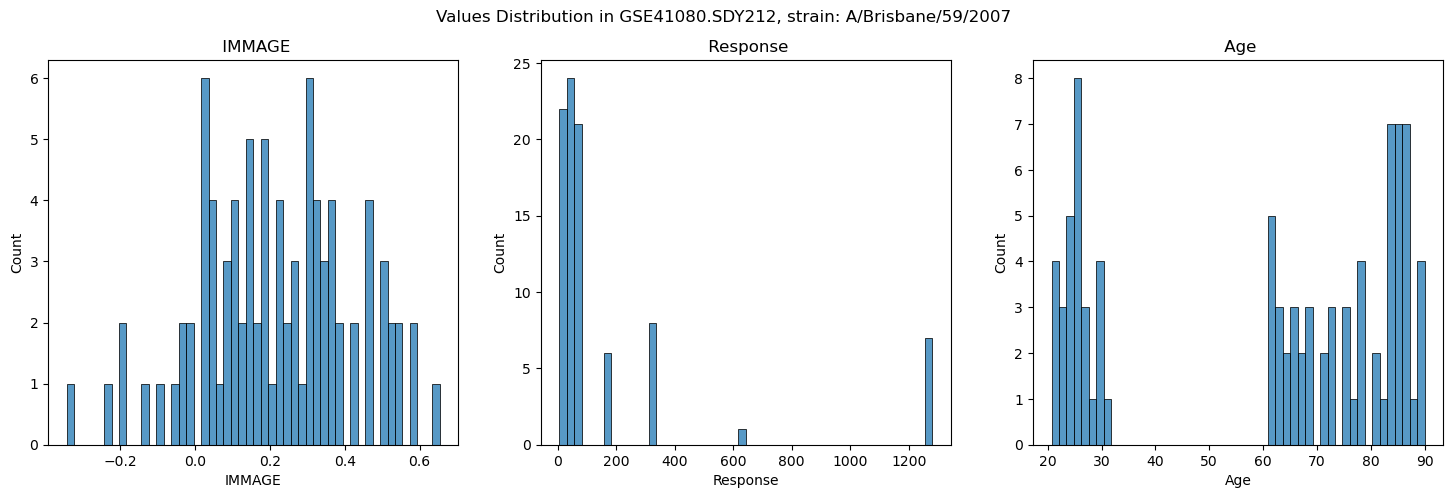

In [247]:
# Plot IMMAGE, response, and age values to look at the dynamic range
fig, axs = plt.subplots(1, 3, figsize=(18, 5))  # Adjust figsize as needed
pd.concat
sns.histplot(data=data, x=immage_col, bins=50, ax=axs[0])
axs[0].set_title(f' {immage_col}')
axs[0].set_label(f' {immage_col}')

sns.histplot(data=data, x=response_col, bins=50, ax=axs[1])
axs[1].set_title(f' {response_col}')

sns.histplot(data=data, x=age_col, bins=50, ax=axs[2])
axs[2].set_title(f' {age_col}')

fig.suptitle(f'Values Distribution in {dataset_name}, strain: {strain}')

plt.show()

##### Is there a trend like we expect? (High IMMAGE ⇒ low response)

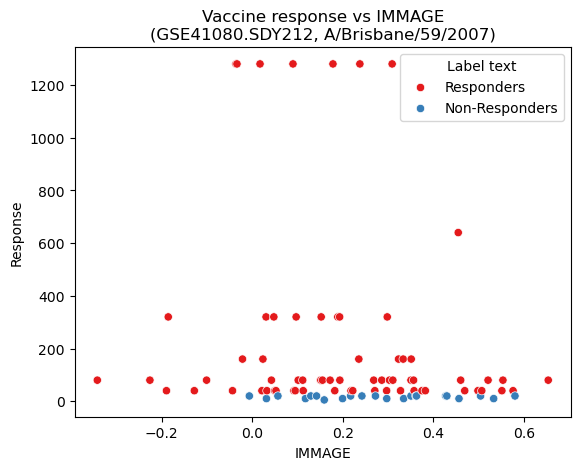

In [248]:
# Plot the response value against sorted IMMAGE, with markers signifying labels
sorted_data = data.sort_values(by="IMMAGE")
sns.scatterplot(data=sorted_data, x="IMMAGE", y="Response", hue="Label text", palette='Set1')
plt.title(f'Vaccine response vs IMMAGE\n({dataset_name}, {strain})')
plt.show()

In [249]:
# ##### We can already see that we won't be able to properly separate responders from non-responders.

In [250]:
# Running a t-test
low_group = data.loc[data[response_col]  < low_response_thr, immage_col]
high_group = data.loc[data[response_col]  >= low_response_thr, immage_col]
# print(f"low group N={low_group.shape[0]}, high group N={high_group.shape[0]}")

ttest = ttest_ind(low_group, high_group)
# print(f"pvalue: {ttest.pvalue}")

##### Classifying with logistic regression - cross validation

In [251]:
# Classifying with logistic regression - cross validation
log_regress = LogisticRegression()
regression_result = cross_validate(log_regress, data[[immage_col]],  data["y"])
print(f"Mean classification accuracy (logistic regression): {regression_result['test_score'].mean()}")

Mean classification accuracy (logistic regression): 0.7529411764705882


##### Classifying with logistic regression - fitting the entire dataset, and checcking the threshold

In [252]:
# Classifying with logistic regression - fit on the entire dataset
from math import log

# Split the data into training and testing sets
# X_train, X_test, labels_train, labels_test = train_test_split(data[[immage_col]], data["y"],
                                                              # test_size=0.2, random_state=42)
# log_regress.score(X_test, labels_test)

def get_threshold_from_probability(prob, intercept, slope):
  return -1 * (log(1/prob - 1) + intercept)/slope

log_regress.fit(data[[immage_col]],  data["y"])
intercept = log_regress.intercept_[0]
slope = log_regress.coef_[0][0]

# Calculate the cutoff value
# print(f' intercept: {intercept}, slope: {slope}')
cutoff = get_threshold_from_probability(0.5, intercept=intercept, slope=slope) # 0.5 is the default threshold

print(f"IMMAGE cutoff value is: {cutoff}")

IMMAGE cutoff value is: 1.5176175376154741


In [253]:
# Plot the logistic regression decision function
from scipy.special import expit
dft = pd.DataFrame()
dft["x"] = np.linspace(-1, 1, 500)
dft["y"] = intercept + dft.x * slope
dft["y2"] = expit(dft.x)
dft["y3"] = expit(dft.y)
# sns.lineplot(data=dft, x="x", y="y2")
# sns.lineplot(data=dft, x="x", y="y3")
# plt.title(f'expit and expit(a*X + b)\n({dataset_name}, {strain})')
# plt.show()

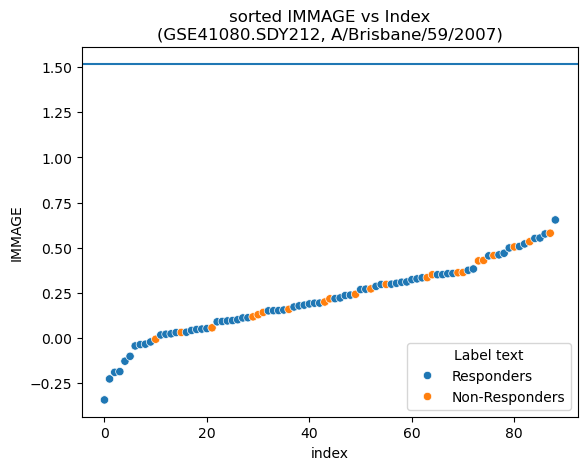

In [254]:
# Plot IMMAGE values and the cutoff
sns.scatterplot(data=data.sort_values(immage_col, ignore_index=True).reset_index(), x="index", y=immage_col, hue="Label text")
# commented out since cutoff is much higher and messes with the plot
plt.axhline(y=cutoff)
plt.title(f'sorted IMMAGE vs Index\n({dataset_name}, {strain})')
plt.show()

##### Logistic regreesion preforms badly, but maybe it still assigns probabilities in a way that makes sense?

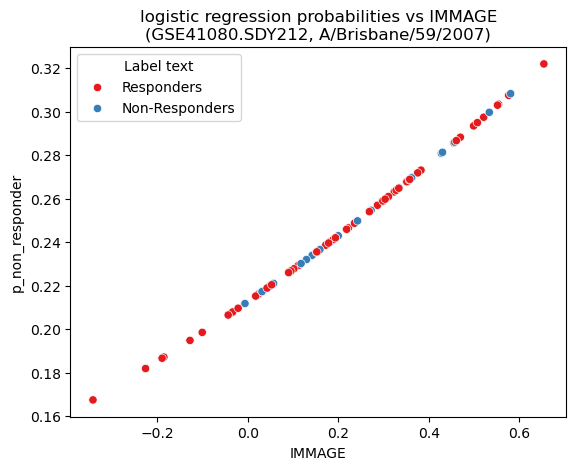

In [255]:
proba = pd.DataFrame(log_regress.predict_proba(data[["IMMAGE"]]))
data["p_non_responder"] = proba[1]
# data["p_non_responder"].hist()
# data.plot.scatter(immage_col, "p_non_responder")

sns.scatterplot(data=data, x="IMMAGE", y="p_non_responder", hue="Label text", palette='Set1')
plt.title(f'logistic regression probabilities vs IMMAGE\n({dataset_name}, {strain})')
plt.show()

In [256]:
# ##### So we see that higher IMMAGE are associated with a higher probability of *not* responding.

That's a good sign that the regressor picked up on an underlying dynamic in the direction that we were expecting.

##### Since this is the case, maybe an ROC curve where we shift the decision threshold based on probability will still work. (The default for log. reg. is to put the decision boundary at p=0.5)

##### The focus here is to find a threshold for classifying *non-repsponders* which maximizes the proportion of non-responders in the predicted group, not caring about predicting responders for now.  

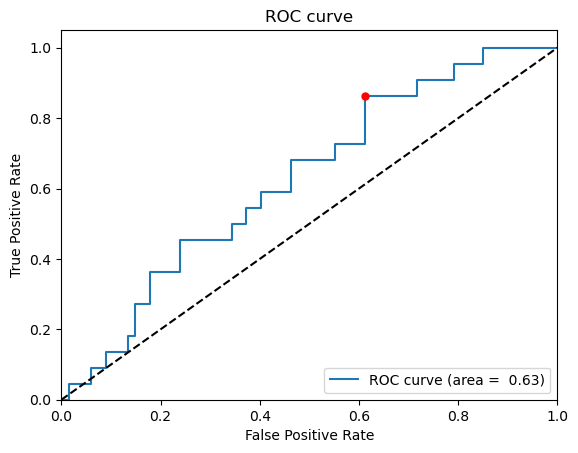

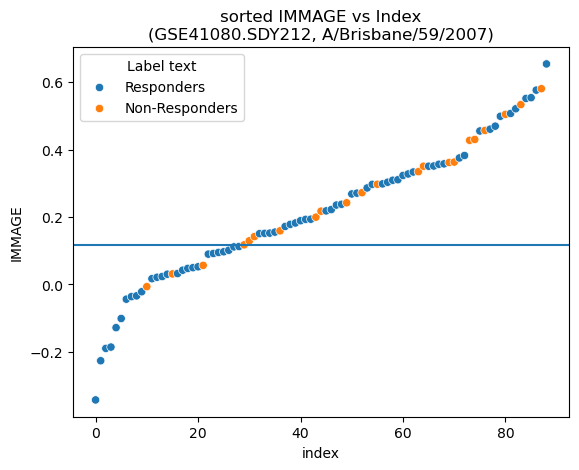

Optimal threshold:  0.12 (IMMAGE value), Non-responder rate: over threshold: 0.31666666666666665, under threshold: 0.10344827586206896


In [257]:
from sklearn.metrics import auc, roc_auc_score, roc_curve
from math import log

fpr, tpr, thresholds = roc_curve(data["y"], data["p_non_responder"])
roc_auc = auc(fpr, tpr)

# Identifying the optimal threshold (example using Youden’s Index)
optimal_idx = np.argmax(tpr - fpr)
prob_threshold = thresholds[optimal_idx]

# print(f'intercept: {intercept}, slope: {slope}')
# Calculate the cutoff value
immage_threshold = get_threshold_from_probability(prob_threshold, intercept=intercept, slope=slope)


# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc : 0.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Random chance line
plt.plot(fpr[optimal_idx], tpr[optimal_idx], marker='o', markersize=5, color="red")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

# Plot IMMAGE values and the cutoff
sns.scatterplot(data=data.sort_values(immage_col, ignore_index=True).reset_index(), x="index", y=immage_col, hue="Label text")
plt.axhline(y=immage_threshold)
plt.title(f'sorted IMMAGE vs Index\n({dataset_name}, {strain})')
plt.show()


# Calculate the actual rate of non-responders:for i in threshold_list:
# Global measures (entire dataset)
optimal_pred = data["p_non_responder"].apply(lambda x: 1 if x >= prob_threshold else 0)
test_accuracy = accuracy_score(data["y"], optimal_pred)

# Performance above the threshold
y_over_thr = data.loc[data["p_non_responder"] >= prob_threshold, ["y"]]
non_response_rate_over_thr = y_over_thr.mean().y
y_under_thr = data.loc[data["p_non_responder"] < prob_threshold, ["y"]]
non_response_rate_under_thr = y_under_thr.mean().y
print(f"Optimal threshold: {immage_threshold : 0.2f} (IMMAGE value), Non-responder rate: over threshold: {non_response_rate_over_thr}, under threshold: {non_response_rate_under_thr}")

An alternative is to try hard IMMAGE-based thresholds:


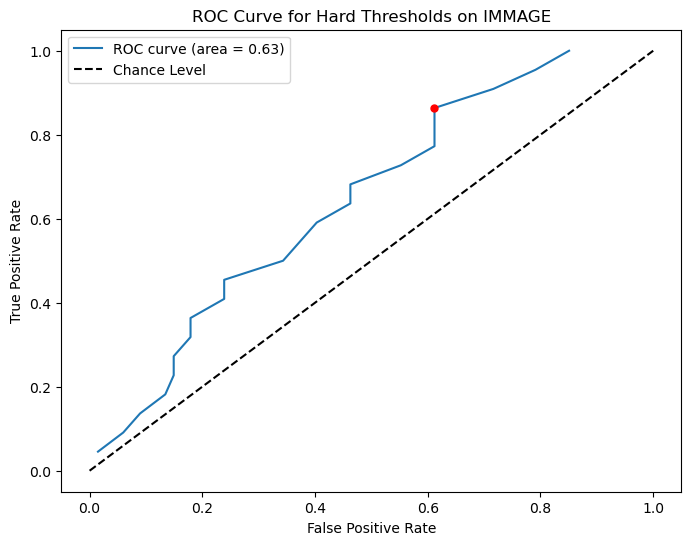

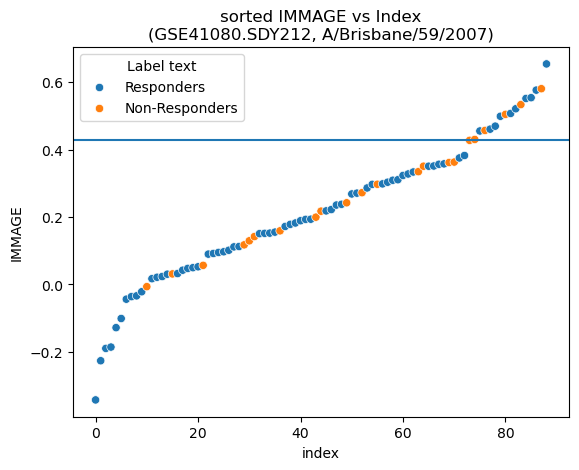

Optimal threshold:  0.43 (IMMAGE value), Non-responder rate: over threshold:  0.38, under threshold:  0.22


In [258]:
# Manually create threshold values. Only take y=1 (non-responders) as thresholds.
sorted_values = pd.DataFrame(pd.unique(data.loc[data["y"] == 1, immage_col])).sort_values(by=0)
thresholds = sorted_values[0]
roc_points = []

for t in thresholds:
    # Binary predictions based on the current threshold
    y_pred = (data[immage_col] >= t).astype(int)

    # Calculate TPR and FPR for the current set of binary predictions.
    # When roc_curve is given a binary array instead of probabilities, it calculates the fpr and tpr for the single threshold that they represent
    fpr, tpr, _ = roc_curve(data["y"], y_pred)
    roc_points.append((fpr[1], tpr[1]))  # Assuming single threshold; fpr and tpr have two elements


# Separate FPR and TPR values for plotting
fprs, tprs = zip(*roc_points)
fpr = pd.DataFrame(fprs).values
tpr = pd.DataFrame(tprs).values

# Identifying the optimal threshold (example using Youden’s Index)
optimal_idx = np.argmax(tpr - fpr)
immage_threshold = thresholds[optimal_idx]

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='Chance Level')
plt.plot(fpr[optimal_idx], tpr[optimal_idx], marker='o', markersize=5, color="red")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Hard Thresholds on IMMAGE')
plt.legend()
plt.show()

# Plot IMMAGE values and the cutoff
sns.scatterplot(data=data.sort_values(immage_col, ignore_index=True).reset_index(), x="index", y=immage_col, hue="Label text")
plt.axhline(y=immage_threshold)
plt.title(f'sorted IMMAGE vs Index\n({dataset_name}, {strain})')
plt.show()

# Calculate the actual rate of non-responders:for i in threshold_list:
# Global measures (entire dataset)
optimal_pred = data[immage_col].apply(lambda x: 1 if x >= immage_threshold else 0)
test_accuracy = accuracy_score(data["y"], optimal_pred)

# Performance above the threshold
y_over_thr = data.loc[data[immage_col] >= immage_threshold, ["y"]]
non_response_rate_over_thr = y_over_thr.mean().y
y_under_thr = data.loc[data[immage_col] < immage_threshold, ["y"]]
non_response_rate_under_thr = y_under_thr.mean().y
print(f"Optimal threshold: {immage_threshold : 0.2f} (IMMAGE value), Non-responder rate: over threshold: {non_response_rate_over_thr : 0.2f}, under threshold: {non_response_rate_under_thr : 0.2f}")

##### Which give a different threshold with the same AUC score

##### Another option it to bin IMMAGE values and look for where the rate of non-responders changes
##### TODO: We can make this more elaborate by using different number of bins

In [259]:
###### Bin the data based on IMMAGE, look for a change in non-responder rate (proportion)

n_bins = 6
B = pd.cut(data["IMMAGE"], bins=n_bins, labels=range(n_bins))
data["bin"] = B.values.astype(int)

grouped = data.groupby("bin", as_index=False)['y'].mean()

t = pd.DataFrame({"bin" : grouped["bin"], "NR rate": grouped["y"]})
print(t)

   bin   NR rate
0    0  0.000000
1    1  0.000000
2    2  0.230769
3    3  0.250000
4    4  0.368421
5    5  0.300000


#### Another option is to choose the threshold that gives the highest rate of non-responders. The question is how to regularize it so it won't give us only the last samples in cases where they are all positive (non-responders)

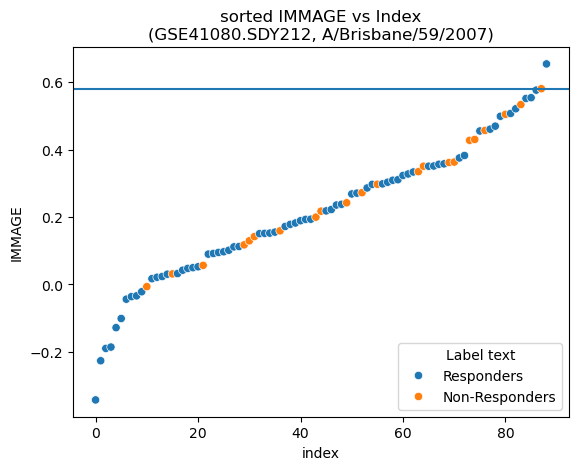

Optimal threshold:  0.58 (IMMAGE value), Non-responder rate: over threshold:  0.50, under threshold:  0.24


In [260]:
# Manually create threshold values. Only take y=1 (non-responders) as thresholds.
sorted_values = pd.DataFrame(pd.unique(data.loc[data["y"] == 1, immage_col])).rename(columns={0:"threshold"}).sort_values(by="threshold").reset_index(drop=True)
thresholds = sorted_values
# thresholds = sorted_values["threshold"]
# rates = pd.Series(name="rates")
rates = []

for i, t in thresholds.itertuples():
    # Binary predictions based on the current threshold
    rates.append(data.loc[data[immage_col] >= t,"y"].mean())

rates = pd.Series(rates)
threshold_idx = rates.argmax()
immage_threshold = thresholds["threshold"].iloc[threshold_idx]

# Plot IMMAGE values and the cutoff
sns.scatterplot(data=data.sort_values(immage_col, ignore_index=True).reset_index(), x="index", y=immage_col, hue="Label text")
plt.axhline(y=immage_threshold)
plt.title(f'sorted IMMAGE vs Index\n({dataset_name}, {strain})')
plt.show()

# Calculate the actual rate of non-responders:for i in threshold_list:
# Global measures (entire dataset)
optimal_pred = data[immage_col].apply(lambda x: 1 if x >= immage_threshold else 0)
test_accuracy = accuracy_score(data["y"], optimal_pred)

# Performance above the threshold
y_over_thr = data.loc[data[immage_col] >= immage_threshold, ["y"]]
non_response_rate_over_thr = y_over_thr.mean().y
y_under_thr = data.loc[data[immage_col] < immage_threshold, ["y"]]
non_response_rate_under_thr = y_under_thr.mean().y
print(f"Optimal threshold: {immage_threshold : 0.2f} (IMMAGE value), Non-responder rate: over threshold: {non_response_rate_over_thr : 0.2f}, under threshold: {non_response_rate_under_thr : 0.2f}")